# Probabilistic Autoencode on LHCO data

## Import machine lerning libraries

In [1]:
import sys
import numpy as np
import pandas as pd

sys.path.append("../")

from pae.models.autoencoder import DenseAutoencoder
from pae.models.flows import MAF
from pae.models.nn import PaeBuilder

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as tfk

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
from tensorflow.python.client import device_lib

devices = tf.config.list_physical_devices()
print("tensorflow", tf.__version__)
print("tensorflow-probability", tfp.__version__)
print("Available devices:", *[dev[1] for dev in devices])

SEED = 42
np.random.seed(SEED) 
tf.random.set_seed(SEED)

tensorflow 2.4.1
tensorflow-probability 0.12.1
Available devices: CPU GPU


## Plotting libraries 

In [4]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected = True)
pio.templates.default = "plotly_dark"


## Data loading and preprocessing

In [5]:
from pae.utils import load_json, dump_json

from pae.loaders.LHCO import ScalarLoaderLHCO, ImageLoaderLHCO, DatasetBuilder

x = ImageLoaderLHCO.from_json("../pae/configs/loader/images_rnd.json")
mjj = ScalarLoaderLHCO.from_json("../pae/configs/loader/scalar_mjj.json")
builder = DatasetBuilder(x, mjj)
builder.data_preparation(sample_sizes ={'sig':10_000, 'bkg': 20_000}, fit_key='bkg')
dataset = builder.make_dataset(train = {'bkg':10_000}, test={'sig':10_000, 'bkg': 10_000}, shuffle=False)

## Density estimation of $m_{jj}$

In [6]:
from pae.density import GMM, ConvKDE

gmm=GMM(n_components=200, covariance_type='full')
gmm.fit(dataset["mjj_train"])
y_gmm = gmm.evaluate(dataset["mjj_train"])

fftkde = ConvKDE()
fftkde.fit(dataset["mjj_train"], range=(1000, 9500)) 
y_kde = fftkde.evaluate(dataset["mjj_train"])


In [12]:
x_ref = np.linspace(1500, 8000, 1701)
y_gmm = gmm.evaluate(x_ref.reshape(-1,1))
y_kde = fftkde.evaluate(x_ref)

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_ref, y=y_gmm, mode='lines', name='GMM',
                         line={'color': 'greenyellow', 'width': 2, 'dash': 'dot'}))
fig.add_trace(go.Scatter(x=x_ref, y=y_kde, mode='lines', name='FFTKDE',
                         line={'color': 'indianred', 'width': 2, 'dash': 'dash'}))
fig.add_trace(go.Histogram(x=dataset["mjj_train"].ravel(), nbinsx=600, histnorm='probability density', 
                           marker_color='steelblue', name='Histnorm'))
fig.update_layout(
    title_text='Dijet mass distribution and density estimation',
    xaxis_title_text=r'$$m_{jj}$$',
    yaxis_title_text=r'density',
)
fig.show('vscode')

### Computing Weights

In [29]:
data = dataset['mjj_train']

w_gmm = gmm.get_weights(data)
w_kde = fftkde.get_weights(data.ravel())

fig = go.Figure()
fig.add_trace(go.Scattergl(x=data.ravel(), y=w_gmm, 
                           mode='markers', name='GMM', opacity=0.8,
                           marker=dict(color='greenyellow',symbol='diamond'))
            )
fig.add_trace(go.Scattergl(x=data.ravel(), y=w_kde, 
                           mode='markers', name='FFTKDE', opacity=0.8,
                           marker=dict(color='indianred',symbol='star-square'))
            )
fig.update_layout(
    title_text='Weights relative to dijetmass scatter plot',
    xaxis_title_text=r'$$m_{jj}$$',
    yaxis_title_text=r'weight',
)
fig.show('vscode')

In [31]:
n_kde, b = np.histogram(data.ravel(), bins=30, weights=w_kde)
n_gmm, _ = np.histogram(data.ravel(), bins=b, weights=w_gmm)

fig = go.Figure()       
fig.add_trace(go.Bar(x=b[:-1], y=n_kde, name='FFTKDE',
                           marker=dict(color='indianred'))
            )
fig.add_trace(go.Bar(x=b[:-1], y=n_gmm, name='GMM',
                        marker=dict(color='yellowgreen'))
            )
fig.update_layout(
    title_text=r'Weighted dijet mass bins',
    xaxis_title_text=r'$$m_{jj}$$',
    yaxis_title_text=r'Counts',
    bargap=0.1
)
fig.show('vscode')

## Network creation

In [6]:
from tensorflow.keras.models import Sequential
from pae.models.autoencoder import Autoencoder
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras import layers

class CNNAE(Autoencoder):
    def __init__(self, enc, dec, **kwargs):
        super().__init__(**kwargs)
        self.encoder = enc
        self.decoder = dec
    def call(self, inputs):
        """Run the inputs through the full autoencoder"""
        encoding = self.encoder(inputs)
        reconstructed = self.decoder(encoding)
        return reconstructed
    
    def encode(self, inputs):
        """Genereate the latent representation of the inputs"""
        return self.encoder(inputs).numpy()

    def decode(self, encoding):
        """Reconstruct the inputs using a given latent representation"""
        return self.decoder(encoding).numpy()

batch_size = 32
img_height = 64
img_width = 64
latent_dim = 10

l1 = 1e-5 
l2 = 1e-5

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
)


enc = Sequential([
  layers.InputLayer(input_shape=(img_height, img_width, 1)),
  layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(latent_dim, activation='sigmoid'),
])

dec = Sequential([
  layers.InputLayer(input_shape=(latent_dim, )),
  layers.Dense(units=2048, activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.Reshape(target_shape=(8, 8, 32)),
  layers.UpSampling2D(),
  layers.Conv2DTranspose(32, 3, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.UpSampling2D(),
  layers.Conv2DTranspose(16, 3, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.UpSampling2D(),
  layers.Conv2DTranspose(8, 3, padding='same', activation='relu', kernel_regularizer=L1L2(l1,l2)),
  layers.Conv2D(1, 3, padding='same', activation='sigmoid'),
])

enc.summary()
dec.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [7]:
from tensorflow.keras.models import Sequential

builder = PaeBuilder()

ae = CNNAE(enc,dec)

nf_config = {
    'n_dims':10, 
    'n_layers':5, 
    'units':[32 for i in range(4)]
}
optimizer_ae = {
    'lr': 0.001
}
optimizer_nf = {
    'lr': 0.005
}

builder._ae = ae
builder.make_ae_optimizer(tfk.optimizers.Adam, optimizer_ae)
builder.make_nf_model(MAF, nf_config)
builder.make_nf_optimizer(tfk.optimizers.Adam, optimizer_nf)
builder.compile_ae(loss='mse')
builder.compile_nf()
pae = builder.pae

In [9]:
#w_kde_valid = fftkde.get_weights(dataset["mjj_valid"])
#w_gmm_valid = gmm.get_weights(dataset["mjj_valid"])

ae_train ={
    'batch_size':16,
    'epochs':40,
    #'sample_weight':w_kde,
    'validation_data':(dataset["x_valid"],dataset["x_valid"]),#,w_kde_valid),
    'callbacks':tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=10,
        verbose=1
    )
}

nf_train ={
    'batch_size':100,
    'epochs':200,
    'validation_data':(dataset["x_valid"],dataset["x_valid"]),
    'callbacks':tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=5,
        verbose=1
    )
}
with tf.device("/device:GPU:0"):
    %time pae.fit(dataset["x_train"],None,ae_train,nf_train)

33.1007 - val_loss: -38.5882
Epoch 13/200
80/80 [==============================] - 0s 5ms/step - loss: -37.9303 - val_loss: -37.8476
Epoch 14/200
80/80 [==============================] - 0s 5ms/step - loss: -35.0128 - val_loss: -33.9336
Epoch 15/200
80/80 [==============================] - 0s 5ms/step - loss: -36.1832 - val_loss: -38.3675
Epoch 16/200
80/80 [==============================] - 0s 5ms/step - loss: -40.5495 - val_loss: -33.1139
Epoch 17/200
80/80 [==============================] - 0s 6ms/step - loss: -38.1515 - val_loss: -42.6274
Epoch 18/200
80/80 [==============================] - 0s 5ms/step - loss: -41.0637 - val_loss: -41.9337
Epoch 19/200
80/80 [==============================] - 0s 5ms/step - loss: -38.9019 - val_loss: -41.5123
Epoch 20/200
80/80 [==============================] - 0s 5ms/step - loss: -42.7244 - val_loss: -17.1059
Epoch 21/200
80/80 [==============================] - 0s 6ms/step - loss: -39.6921 - val_loss: -47.2090
Epoch 22/200
80/80 [===============

### Training metrics

In [10]:
from pae.plotting import loss_plot

fig = loss_plot(pae.history)
fig.show('vscode')

In [11]:
#with tf.device("/device:CPU:0"):
z_true = pae.ae.encode(dataset['x_train'])
z_sample = pae.nf.sample(dataset['x_train'].shape[0])

In [12]:
from pae.plotting import latent_space_plot

fig = latent_space_plot(z_true, z_sample)
fig.show('vscode')

## Analysis

In [13]:
import matplotlib.pyplot as plt


img = pae.ae.decode(z_true[:100])


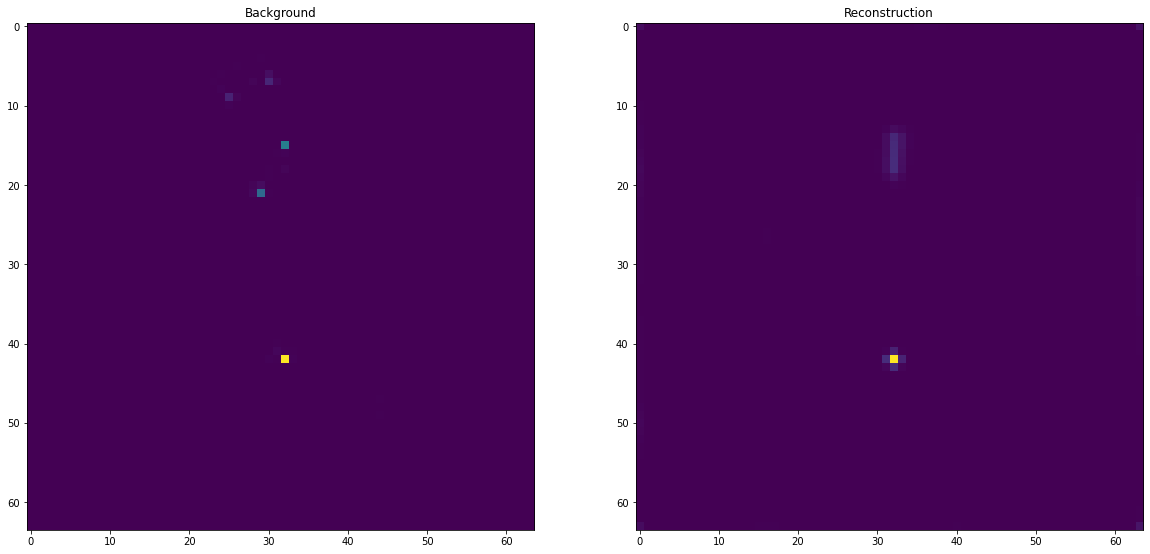

In [20]:
no=13

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('Background')
plt.imshow(dataset['x_train'][no])
plt.subplot(1,2,2)
plt.title('Reconstruction')
plt.imshow(img[no])
plt.show()

In [84]:
with tf.device("/device:CPU:0"):
    mse = pae.reco_error(dataset['x_test'], axis=-1)
    sigma = pae.reco_error(dataset['x_valid'], axis=0)
    z = pae.ae.encode(dataset['x_test'])
    byz = pae.nf.inverse(z)
    detJ = pae.nf.inverse_log_det_jacobian(z)

    

In [85]:
with tf.device("/device:CPU:0"):
    ascore = -0.5*np.mean(np.dot(mse,sigma.squeeze(-1)**(-1)), axis=(1,2)) - \
            0.5*np.linalg.norm(byz,axis=1)**2 + detJ

(20000, 64, 64) (64, 64, 1)


In [114]:
mse_test = np.mean(mse, axis =(1,2))
with tf.device("/device:CPU:0"):
    ascore_stable = -0.5*mse_test - \
            0.5*np.linalg.norm(byz,axis=1)**2 #+ detJ

In [101]:
with tf.device("/device:CPU:0"):
    mse_train = pae.reco_error(dataset['x_train'], axis=(1,2,3))

In [118]:
with tf.device("/device:CPU:0"):
    z = pae.ae.encode(dataset['x_train'])
    byz = pae.nf.inverse(z)
    ascore_stable_train = -0.5*mse_train - \
            0.5*np.linalg.norm(byz,axis=1)**2

In [113]:
detJ

array([56.204735, 56.204735, 56.204735, ..., 56.204735, 56.204735,
       56.204735], dtype=float32)

## Plots

In [115]:
prc=95

x_min = np.percentile(ascore, 1)
x_max = np.percentile(ascore, 99)
x_prc = np.percentile(ascore, prc)
i_prc = (ascore >= x_prc)

fig = go.Figure()
fig.add_trace(go.Histogram(x=ascore_stable, name='Test dataset', 
                           marker_color='plum', nbinsx=80),
             )
# fig.add_vline(x=x_prc, y1=5100, line_width=2, line_color='firebrick', 
#               annotation_text=f"{prc}th percentile", 
#               annotation_position="top right",
#               )

fig.update_layout(
    xaxis_title='Anomaly Score',
    #title_text=r'Cut on Anomaly Score',
    width=600)
fig.show('vscode')

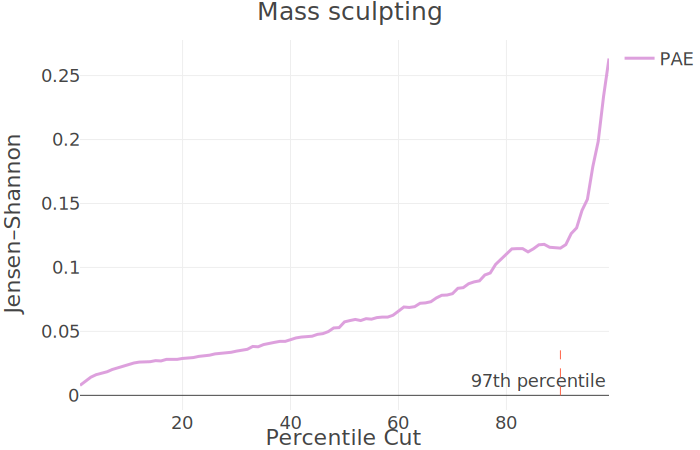

In [119]:
from scipy.spatial.distance import jensenshannon
pio.templates.default = "presentation"
mjj = dataset['mjj_train']
max_prc = 99
score = ascore_stable_train
n_full, b = np.histogram(mjj, bins=60, density=True)
js_div = {}
for prc in range(1, max_prc+1):
    x_prc = np.percentile(score, prc)
    i_prc = np.where(score >= x_prc)[0]
    n_prc, _ = np.histogram(mjj[i_prc], bins=b, density=True)
    js_div[prc] = jensenshannon(n_full,n_prc)

fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash', color="tomato", width=1),
    x0=90, x1=90, y0=0, y1=0.04, 
)

fig.add_trace(
    go.Scatter(x=list(js_div.keys()), y=list(js_div.values()), mode='lines',
        name="PAE", line=dict(color="plum", width=3))
)


fig.add_trace(go.Scatter(
    x=[86],
    y=[0.003],
    mode="text",
    text=["97th percentile"],
    textposition="top center",
    showlegend=False
))

fig.update_layout(
    title_text = "Mass sculpting",
    xaxis_title = "Percentile Cut",
    yaxis_title = "Jensen–Shannon",
    margin={'l': 80, 'b': 40, 't': 40, 'r': 0},
    width=750, height=450

)
fig.show('svg')
#fig.write_image("JS-plot.png")


In [ ]:
# print("Eff:",mjj[i_prc&sig_label].shape[0]/400)
# print("Rej:",1-mjj[i_prc&bkg_label].shape[0]/200_000)

In [121]:
from sklearn.metrics import roc_curve, auc
import plotly.express as px

# def binarize(label):
#     return 1 if label == 'sig' else 0
# labels = np.array(list(map(binarize, dataset['labels'])))
labels = np.concatenate([np.ones(10_000),np.zeros(10_000)])

fpr, tpr, thresholds = roc_curve(labels, ascore_stable)
pae_auc = auc(1-fpr, tpr)
#gan_auc = auc(louis_roc['bkg_rej'], louis_roc['sig1_ef'])

fig = go.Figure()

# fig.add_trace(
#     go.Scatter(x=louis_roc['sig1_ef'], y=louis_roc['bkg_rej'], mode='lines',
#         name=f"GAN-AE (AUC:{gan_auc:.2f})", line=dict(color="LimeGreen", width=2))
# )
fig.add_trace(
    go.Scatter(x=tpr, y=1-fpr, mode='lines',
        name=f"PAE (AUC:{pae_auc:.2f})", line=dict(color="Plum", width=2))
)
fig.add_trace(go.Scatter(
    x=[0.018],
    y=[0.99],
    mode="text",
    text=["97th percentile"],
    textposition="top center",
    showlegend=False
))
fig.update_layout(
    width=500, height=500,
    xaxis_title = "Signal efficiency",
    yaxis_title = "Background Rejection",
    margin={'l': 60, 'b': 60, 't': 40, 'r': 0},
    legend = dict(x=0.5, y=0.9,
        traceorder='normal',
        font=dict(size=15)),
    title_text="ROC curves"
)
fig.add_vline(x=0.0177, line_width=1, line_dash="dash", line_color="firebrick")
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.write_image("ROC2jet.png")
fig.show()

KeyError: 'labels'